# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [3]:
path = '../../../Base de datos con ruido/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [4]:
varftrain = np.load(path + '/varftrain.npy')

In [5]:
np.shape(varftrain)

(7000, 10, 2, 200)

### Coeficientes

In [6]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [7]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [8]:
varftest = np.load(path + '/varftest.npy')

In [9]:
np.shape(varftest)

(2000, 10, 2, 200)

### Coeficientes

In [10]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [11]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [12]:
varfval = np.load(path + '/varfval.npy')

In [13]:
np.shape(varfval)

(1000, 10, 2, 200)

### Coeficienes

In [14]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [15]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [17]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 200), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [18]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [19]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,200)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 4000)             16000     
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 200)               800200    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 100)               5100      
                                                        

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [26]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [27]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [28]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 3s 4ms/step - loss: 20.6730 - mae: 2.4396 - val_loss: 14.8481 - val_mae: 2.2380 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 3s 4ms/step - loss: 13.9891 - mae: 2.2525 - val_loss: 12.5260 - val_mae: 2.1619 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 3s 4ms/step - loss: 12.3309 - mae: 2.1849 - val_loss: 11.5776 - val_mae: 2.1305 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 3s 4ms/step - loss: 11.3272 - mae: 2.1534 - val_loss: 10.9563 - val_mae: 2.1498 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 3s 4ms/step - loss: 10.4265 - mae: 2.1239 - val_loss: 10.0506 - val_mae: 2.0784 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 3s 4ms/step - loss: 10.0279 - mae: 2.1207 - val_loss: 9.4560 - val_mae: 2.0430 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 3s 4ms/step - loss: 9.4402 - mae: 2.1099 - val_loss

700/700 [==============================] - 3s 4ms/step - loss: 5.8251 - mae: 1.8413 - val_loss: 5.3495 - val_mae: 1.7377 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.7770 - mae: 1.8327 - val_loss: 5.4582 - val_mae: 1.7516 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.8017 - mae: 1.8412 - val_loss: 5.2677 - val_mae: 1.7228 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.7966 - mae: 1.8339 - val_loss: 5.3869 - val_mae: 1.7271 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.8040 - mae: 1.8421 - val_loss: 5.2940 - val_mae: 1.7183 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.7852 - mae: 1.8378 - val_loss: 5.3028 - val_mae: 1.7245 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.7610 - mae: 1.8346 - val_loss: 5.1409 - val_mae

700/700 [==============================] - 3s 4ms/step - loss: 5.5843 - mae: 1.8034 - val_loss: 5.3439 - val_mae: 1.7639 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.5703 - mae: 1.7990 - val_loss: 5.4230 - val_mae: 1.7534 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.5855 - mae: 1.8011 - val_loss: 5.2996 - val_mae: 1.7099 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.5507 - mae: 1.7974 - val_loss: 5.1669 - val_mae: 1.7161 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.5673 - mae: 1.7968 - val_loss: 5.2234 - val_mae: 1.7346 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.5563 - mae: 1.7957 - val_loss: 5.5237 - val_mae: 1.7914 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.6106 - mae: 1.8068 - val_loss: 5.4452 - v

700/700 [==============================] - 3s 4ms/step - loss: 5.5046 - mae: 1.7827 - val_loss: 5.3533 - val_mae: 1.7645 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4633 - mae: 1.7754 - val_loss: 5.2303 - val_mae: 1.7260 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.5332 - mae: 1.7865 - val_loss: 4.9259 - val_mae: 1.6418 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4822 - mae: 1.7820 - val_loss: 5.2358 - val_mae: 1.7303 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.4684 - mae: 1.7806 - val_loss: 5.0908 - val_mae: 1.7068 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4842 - mae: 1.7826 - val_loss: 5.1206 - val_mae: 1.6846 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.4577 - mae: 1.7763 - val_loss: 5.1811 - v

700/700 [==============================] - 3s 4ms/step - loss: 5.4450 - mae: 1.7722 - val_loss: 5.1541 - val_mae: 1.7083 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.4630 - mae: 1.7737 - val_loss: 5.3530 - val_mae: 1.7432 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4405 - mae: 1.7714 - val_loss: 5.0515 - val_mae: 1.6952 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4449 - mae: 1.7725 - val_loss: 5.0771 - val_mae: 1.6867 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4777 - mae: 1.7755 - val_loss: 5.1143 - val_mae: 1.6995 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4283 - mae: 1.7710 - val_loss: 5.0265 - val_mae: 1.6744 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4267 - mae: 1.7689 - val_loss: 5.0760 - v

700/700 [==============================] - 3s 4ms/step - loss: 5.4086 - mae: 1.7635 - val_loss: 5.0706 - val_mae: 1.6904 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4288 - mae: 1.7684 - val_loss: 5.1980 - val_mae: 1.6922 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4579 - mae: 1.7731 - val_loss: 5.1621 - val_mae: 1.6849 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4584 - mae: 1.7773 - val_loss: 5.1464 - val_mae: 1.6820 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4214 - mae: 1.7677 - val_loss: 5.0933 - val_mae: 1.6799 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.3849 - mae: 1.7563 - val_loss: 5.2570 - val_mae: 1.7118 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4141 - mae: 1.7638 - val_loss: 4.9889 - v

700/700 [==============================] - 2s 3ms/step - loss: 5.3614 - mae: 1.7575 - val_loss: 5.1815 - val_mae: 1.6950 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.3933 - mae: 1.7623 - val_loss: 5.3788 - val_mae: 1.7175 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3969 - mae: 1.7638 - val_loss: 4.9513 - val_mae: 1.6320 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3598 - mae: 1.7520 - val_loss: 5.2522 - val_mae: 1.6923 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.4280 - mae: 1.7673 - val_loss: 5.0611 - val_mae: 1.6691 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3952 - mae: 1.7638 - val_loss: 5.0362 - val_mae: 1.6577 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.4101 - mae: 1.7637 - val_loss: 5.0314 - v

700/700 [==============================] - 2s 4ms/step - loss: 5.3499 - mae: 1.7552 - val_loss: 5.1033 - val_mae: 1.7091 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4101 - mae: 1.7638 - val_loss: 5.1776 - val_mae: 1.6770 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3847 - mae: 1.7554 - val_loss: 5.0986 - val_mae: 1.7065 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3998 - mae: 1.7615 - val_loss: 5.0117 - val_mae: 1.6830 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4140 - mae: 1.7652 - val_loss: 5.2680 - val_mae: 1.7330 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3583 - mae: 1.7565 - val_loss: 4.9750 - val_mae: 1.6421 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.4219 - mae: 1.7654 - val_loss: 5.0354 - v

700/700 [==============================] - 2s 3ms/step - loss: 5.3668 - mae: 1.7571 - val_loss: 5.0245 - val_mae: 1.6657 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3658 - mae: 1.7580 - val_loss: 5.1564 - val_mae: 1.7051 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.3722 - mae: 1.7596 - val_loss: 5.0504 - val_mae: 1.6734 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.3290 - mae: 1.7497 - val_loss: 4.9933 - val_mae: 1.6486 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3392 - mae: 1.7521 - val_loss: 4.9205 - val_mae: 1.6269 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3291 - mae: 1.7512 - val_loss: 4.8367 - val_mae: 1.6083 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3501 - mae: 1.749

Epoch 494/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2974 - mae: 1.7407 - val_loss: 4.9279 - val_mae: 1.6471 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2979 - mae: 1.7477 - val_loss: 5.0713 - val_mae: 1.6912 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.3075 - mae: 1.7473 - val_loss: 4.9701 - val_mae: 1.6603 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3094 - mae: 1.7439 - val_loss: 5.1476 - val_mae: 1.7047 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.3167 - mae: 1.7501 - val_loss: 5.0765 - val_mae: 1.7091 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2971 - mae: 1.7443 - val_loss: 4.9768 - val_mae: 1.6615 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.31

700/700 [==============================] - 3s 4ms/step - loss: 5.2638 - mae: 1.7412 - val_loss: 4.9638 - val_mae: 1.6482 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2517 - mae: 1.7384 - val_loss: 5.0012 - val_mae: 1.6806 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2694 - mae: 1.7437 - val_loss: 4.9302 - val_mae: 1.6242 - lr: 7.5580e-04
Epoch 550/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2747 - mae: 1.7472 - val_loss: 4.9706 - val_mae: 1.6517 - lr: 7.5415e-04
Epoch 551/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2477 - mae: 1.7415 - val_loss: 5.0295 - val_mae: 1.6752 - lr: 7.5250e-04
Epoch 552/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2842 - mae: 1.7444 - val_loss: 4.9046 - val_mae: 1.6283 - lr: 7.5085e-04
Epoch 553/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2485 - mae: 1.739

Epoch 601/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2644 - mae: 1.7458 - val_loss: 4.9924 - val_mae: 1.6618 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2210 - mae: 1.7362 - val_loss: 4.8701 - val_mae: 1.6308 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1657 - mae: 1.7262 - val_loss: 5.0451 - val_mae: 1.6763 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2245 - mae: 1.7379 - val_loss: 5.0853 - val_mae: 1.6830 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.2448 - mae: 1.7421 - val_loss: 4.9949 - val_mae: 1.6568 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2468 - mae: 1.7424 - val_loss: 5.0129 - val_mae: 1.6562 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.24

700/700 [==============================] - 2s 4ms/step - loss: 5.1868 - mae: 1.7340 - val_loss: 5.0290 - val_mae: 1.6672 - lr: 5.8255e-04
Epoch 655/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1877 - mae: 1.7338 - val_loss: 4.9424 - val_mae: 1.6597 - lr: 5.8090e-04
Epoch 656/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.1948 - mae: 1.7332 - val_loss: 5.0029 - val_mae: 1.6783 - lr: 5.7925e-04
Epoch 657/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1751 - mae: 1.7305 - val_loss: 4.9948 - val_mae: 1.6488 - lr: 5.7760e-04
Epoch 658/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1787 - mae: 1.7298 - val_loss: 4.7778 - val_mae: 1.6265 - lr: 5.7595e-04
Epoch 659/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1618 - mae: 1.7298 - val_loss: 5.1290 - val_mae: 1.7145 - lr: 5.7430e-04
Epoch 660/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.2217 - mae: 1.739

Epoch 708/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1932 - mae: 1.7372 - val_loss: 4.9925 - val_mae: 1.6617 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1508 - mae: 1.7286 - val_loss: 4.9204 - val_mae: 1.6326 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1850 - mae: 1.7374 - val_loss: 4.8400 - val_mae: 1.6447 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.1572 - mae: 1.7300 - val_loss: 4.8418 - val_mae: 1.6389 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 2s 4ms/step - loss: 5.1330 - mae: 1.7233 - val_loss: 4.7878 - val_mae: 1.6246 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1605 - mae: 1.7335 - val_loss: 4.9673 - val_mae: 1.6687 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.15

700/700 [==============================] - 3s 4ms/step - loss: 5.1082 - mae: 1.7248 - val_loss: 4.9051 - val_mae: 1.6560 - lr: 4.0600e-04
Epoch 762/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1007 - mae: 1.7226 - val_loss: 4.7517 - val_mae: 1.6114 - lr: 4.0435e-04
Epoch 763/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1086 - mae: 1.7234 - val_loss: 4.8800 - val_mae: 1.6381 - lr: 4.0270e-04
Epoch 764/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1051 - mae: 1.7239 - val_loss: 4.7898 - val_mae: 1.6266 - lr: 4.0105e-04
Epoch 765/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1050 - mae: 1.7212 - val_loss: 4.8657 - val_mae: 1.6464 - lr: 3.9940e-04
Epoch 766/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1107 - mae: 1.7242 - val_loss: 4.8385 - val_mae: 1.6309 - lr: 3.9775e-04
Epoch 767/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.1107 - mae: 1.721

Epoch 815/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0894 - mae: 1.7200 - val_loss: 4.7858 - val_mae: 1.6212 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0668 - mae: 1.7193 - val_loss: 4.7992 - val_mae: 1.6410 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0776 - mae: 1.7180 - val_loss: 4.9434 - val_mae: 1.6688 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0913 - mae: 1.7239 - val_loss: 4.7656 - val_mae: 1.6277 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0595 - mae: 1.7155 - val_loss: 4.8721 - val_mae: 1.6493 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0695 - mae: 1.7192 - val_loss: 4.7649 - val_mae: 1.6274 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.06

700/700 [==============================] - 3s 4ms/step - loss: 5.0362 - mae: 1.7143 - val_loss: 4.8350 - val_mae: 1.6412 - lr: 2.2945e-04
Epoch 869/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0392 - mae: 1.7150 - val_loss: 4.7650 - val_mae: 1.6223 - lr: 2.2780e-04
Epoch 870/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0289 - mae: 1.7171 - val_loss: 4.7311 - val_mae: 1.6182 - lr: 2.2615e-04
Epoch 871/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0183 - mae: 1.7121 - val_loss: 4.7299 - val_mae: 1.6167 - lr: 2.2450e-04
Epoch 872/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0249 - mae: 1.7117 - val_loss: 4.7746 - val_mae: 1.6332 - lr: 2.2285e-04
Epoch 873/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0219 - mae: 1.7115 - val_loss: 4.6764 - val_mae: 1.6103 - lr: 2.2120e-04
Epoch 874/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0395 - mae: 1.714

Epoch 922/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9783 - mae: 1.7076 - val_loss: 4.6995 - val_mae: 1.6161 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9656 - mae: 1.7018 - val_loss: 4.6724 - val_mae: 1.6113 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9315 - mae: 1.6942 - val_loss: 4.7055 - val_mae: 1.6189 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9540 - mae: 1.6987 - val_loss: 4.7267 - val_mae: 1.6251 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0091 - mae: 1.7111 - val_loss: 4.6931 - val_mae: 1.6150 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 3s 4ms/step - loss: 5.0004 - mae: 1.7104 - val_loss: 4.7334 - val_mae: 1.6216 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.97

700/700 [==============================] - 3s 4ms/step - loss: 4.9677 - mae: 1.7045 - val_loss: 4.5996 - val_mae: 1.5980 - lr: 5.2900e-05
Epoch 976/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9478 - mae: 1.6985 - val_loss: 4.6472 - val_mae: 1.6085 - lr: 5.1250e-05
Epoch 977/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9672 - mae: 1.7032 - val_loss: 4.6735 - val_mae: 1.6194 - lr: 4.9600e-05
Epoch 978/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9722 - mae: 1.7079 - val_loss: 4.6735 - val_mae: 1.6169 - lr: 4.7950e-05
Epoch 979/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9396 - mae: 1.7011 - val_loss: 4.6331 - val_mae: 1.6101 - lr: 4.6300e-05
Epoch 980/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9566 - mae: 1.7024 - val_loss: 4.6386 - val_mae: 1.6064 - lr: 4.4650e-05
Epoch 981/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.9440 - mae: 1.699

# Analizamos accuracy y loss

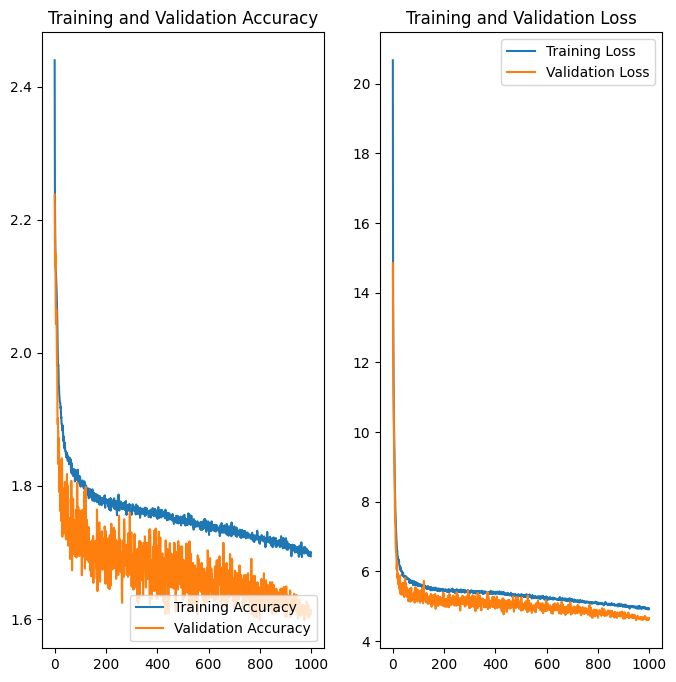

In [29]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [30]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 2ms/step - loss: 4.6622 - mae: 1.6136


In [31]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 1ms/step


In [32]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.6135777257584998, Desviación estándar del error: 2.093853961297098, Error absoluto máximo: 7.905889511108398


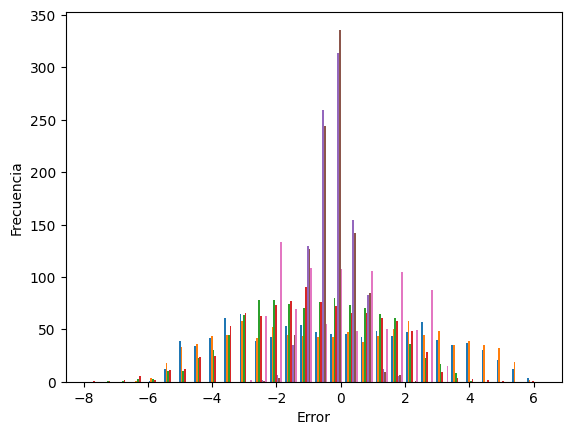

In [33]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [34]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.4673001298068993

In [35]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.6526915073394783

# Guardamos los datos de Accuracy y Loss

In [36]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 100,200/historytrayec200.csv', index=False)

# Guardamos el modelo

In [37]:
path_to_save = '../../../Modelos con ruido/Modelos 100,200'

In [38]:
model.save(path_to_save + '/trayectorias200.h5')

# Importamos el modelo

In [39]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [40]:
import keras
import tensorflow as tf
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/trayectorias200.h5')

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [41]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.025
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[1, 2, 4, 5, 1, 9, 0]
(10, 2, 200)


In [44]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [45]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 52ms/step
[[5. 2. 6. 1. 2. 9. 2.]]


## Graficamos con los coeficientes reales

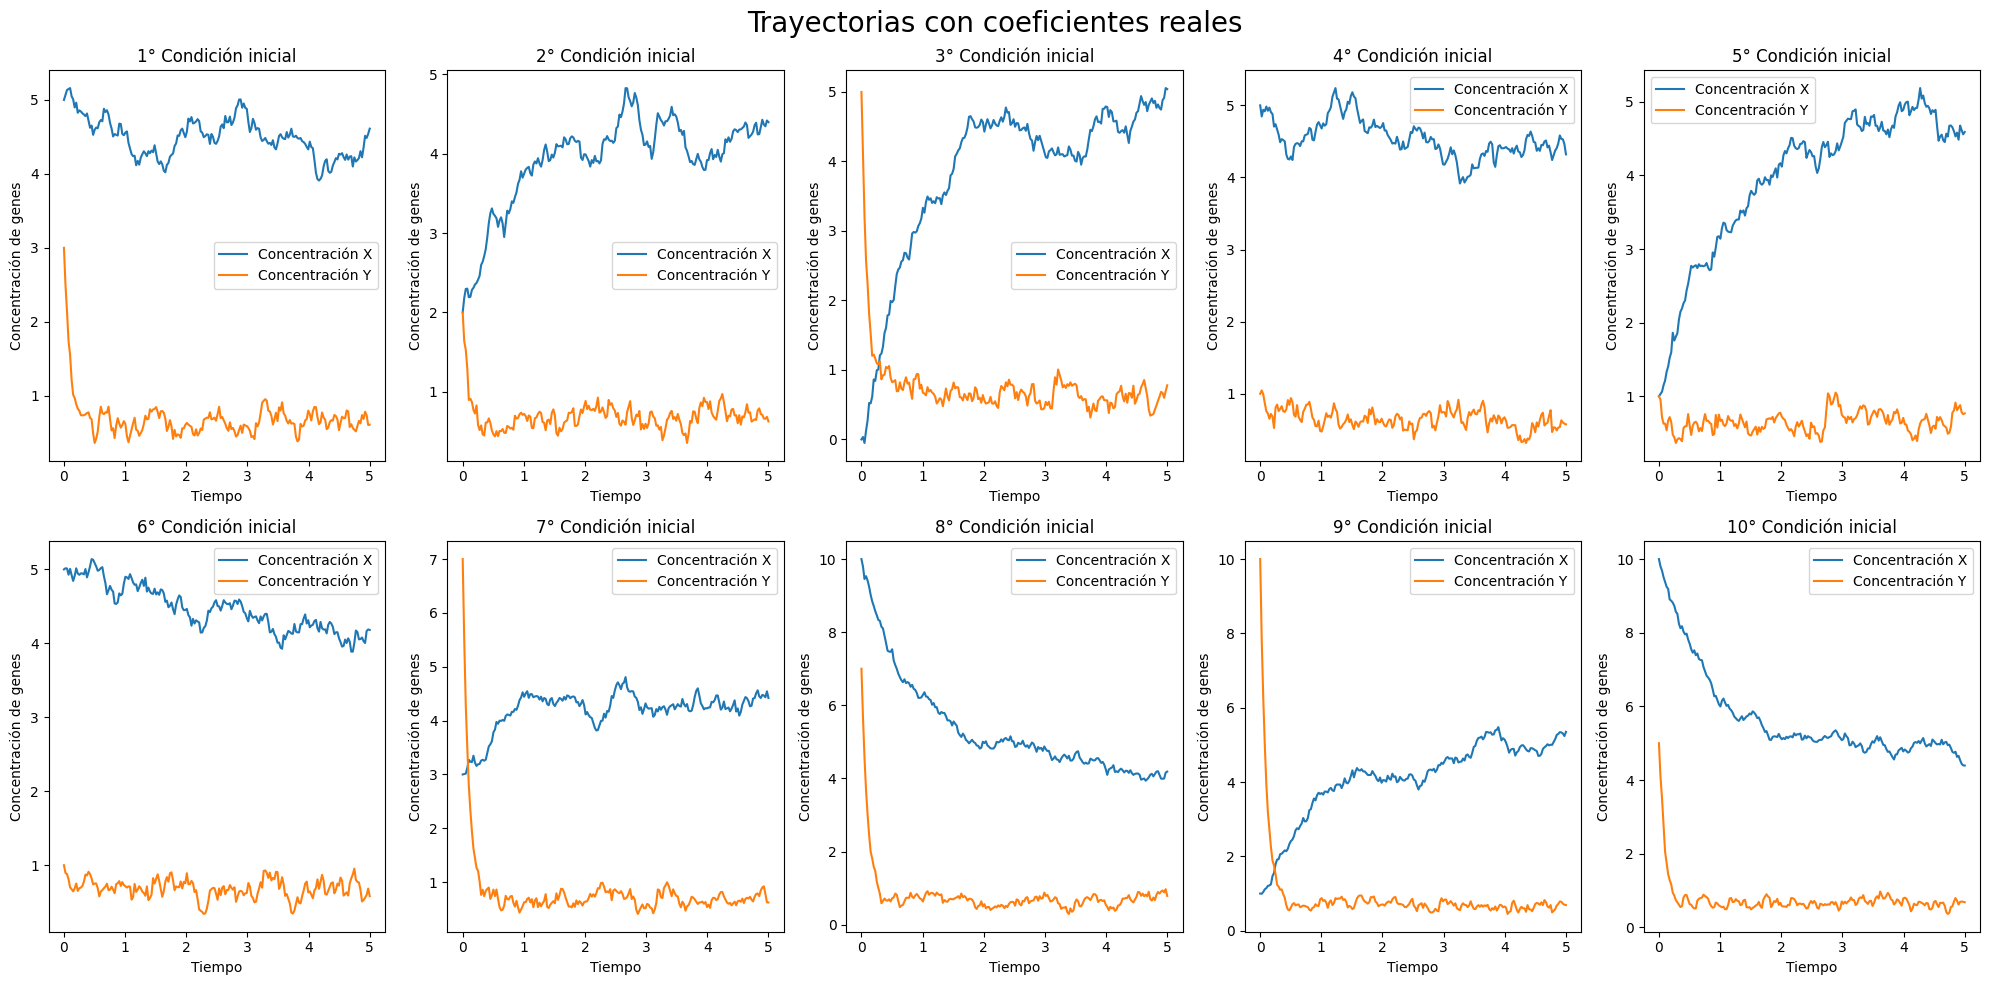

In [46]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

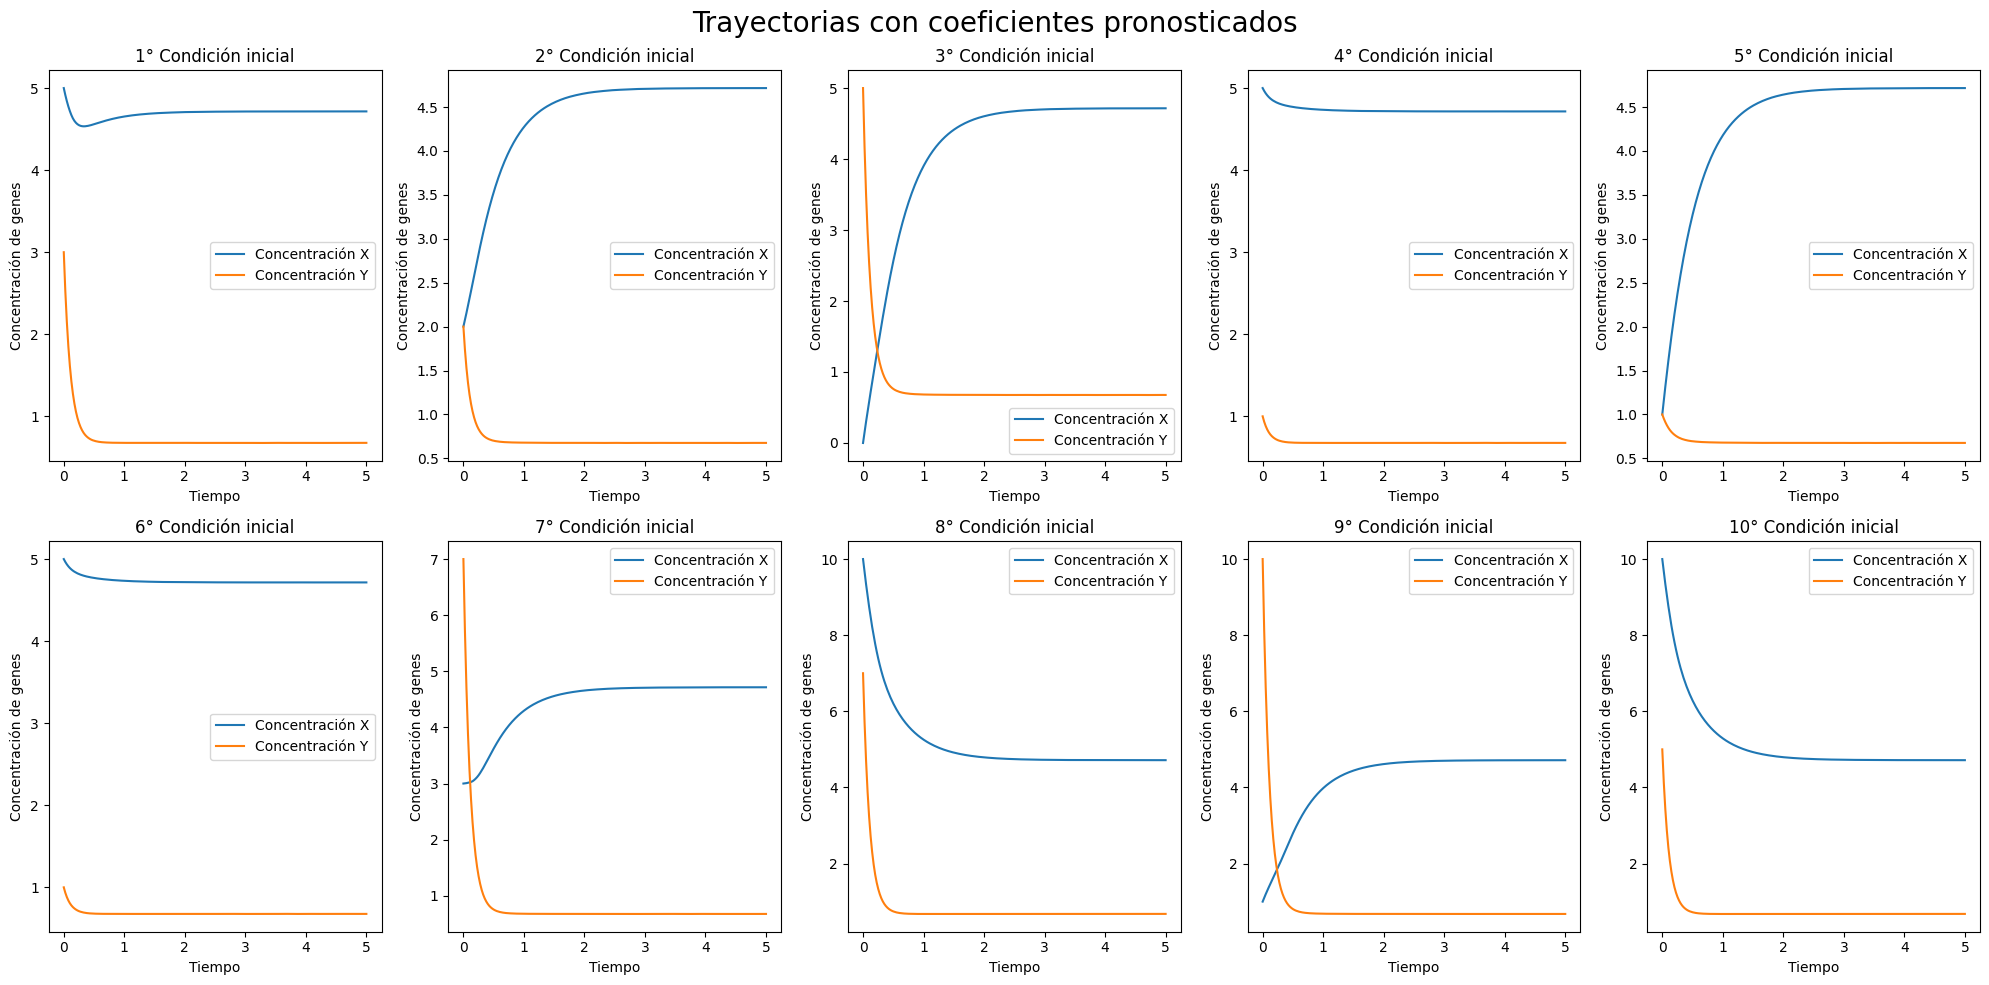

In [47]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

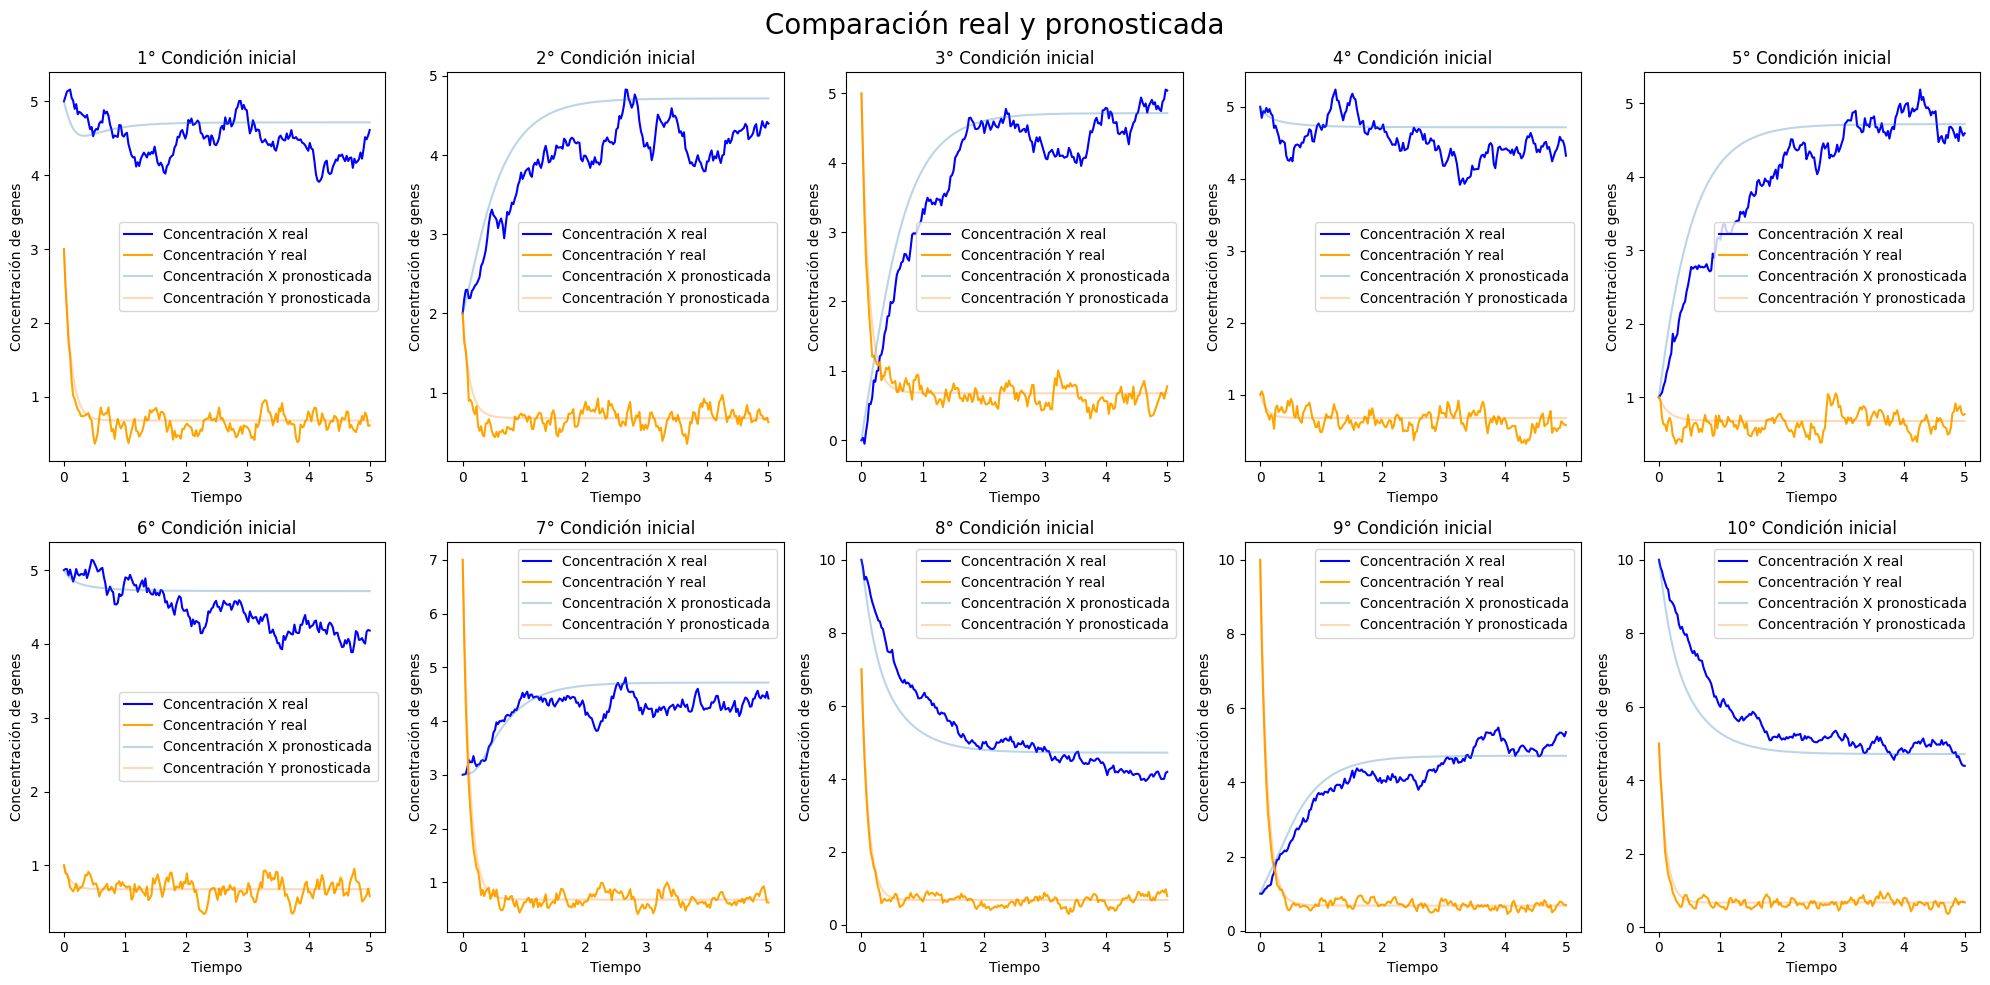

In [48]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

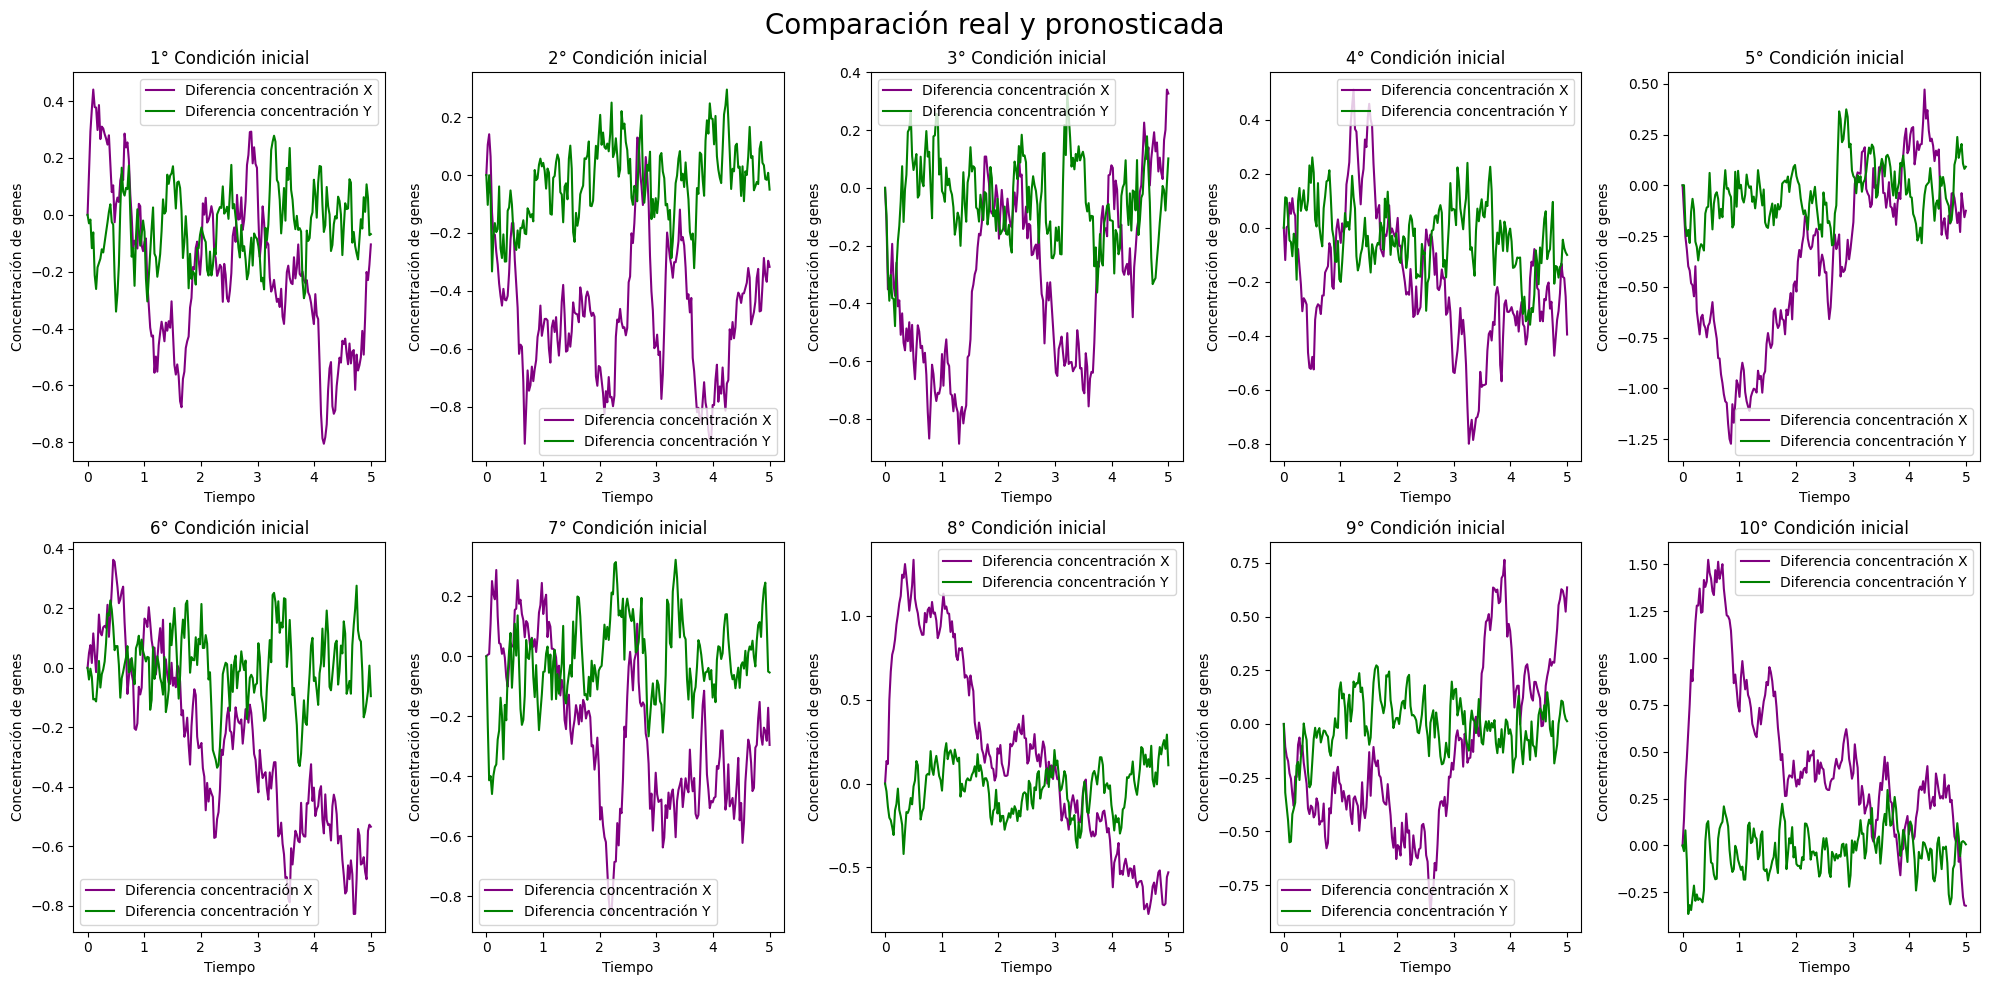

In [49]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [50]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.3819919957803161
0.10752352758192019
